In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import seaborn as sns

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import theano as th
print('theano version: ', th.__version__)

import warnings
warnings.filterwarnings('ignore')


from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import os
import random

('python version: ', '2.7.15 |Anaconda, Inc.| (default, Dec 14 2018, 19:04:19) \n[GCC 7.3.0]')
('pandas version: ', u'0.23.4')
('numpy version: ', '1.15.4')
('scipy version: ', '1.1.0')
('sklearn version: ', '0.19.2')


Using TensorFlow backend.


('keras version: ', '2.1.6')
('keras backend: ', u'tensorflow')
('tensorflow version: ', '1.10.0')
('theano version: ', '0.8.2')


In [2]:
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

In [3]:
excel_file = r'PATH_TO_DATASET'
df = pd.DataFrame(pd.read_csv(excel_file, sep='\t'))
print(df.shape)

(7584, 208)


In [4]:
# Get atc codes
atc_list = []
for i in range(1, 6):
    atc_list.append(df.groupby('atc_%d' % i)['min_effective_dose_%d' % i].first())
atc_codes = pd.concat(atc_list)
atc_codes = atc_codes[~atc_codes.index.duplicated()].index.tolist()

# Set sdd=0 to NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan

# Missing value means not relevant
### One Hot Encoding (All zero stands for NA)
* "Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days" (Y/N/U/NA)
* "recent-start-other-fall-risk-rx" (Y/N/NA)

### Label Encoding & Sin, Cos Transform (NA: (0, 0))
* "mds-cognitive-scale": 
  - 'Independent': 0, 
  - 'Modified Independence': 1, 
  - 'Moderately Impaired': 2, 
  - 'Severely Impaired': 3
* "mds-pain-freq-last-five-days": 
  - 'Continuous': 4, 
  - 'Frequent': 3, 
  - 'Occasional': 2, 
  - 'Rare': 1, 
  - 'Unable to respond': 0,
* "mds-pain-intensity": 
  - 'None': 0, 
  - 'Mild': 1, 
  - 'Moderate': 2, 
  - 'Severe': 3, 
  - 'Very severe, horrible': 4
* "Psychotropic-X": Number
* (Added) "Psychotropic-X-Period": Number


# Drop features

* ~~"Unnamed: 51"~~, 
* ~~"pk-interaction", "pk-interaction-type"~~ 
* ~~"object-drug-1", "object-drug-1-dose", "object-drug-1-effective-dose-increase", "object-drug-1-effective-dose", "interaction-1-stop-date"~~, 
* ~~"object-drug-2", "object-drug-2-dose", "object-drug-2-effective-dose-increase", "object-drug-2-effective-dose", "interaction-2-stop-date"~~
* "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"
* "Blank-1", "Deleted-X" (X from 1 to 12), "Psychotropic-X-average-daily-dose", "Psychotropic-X-Start/End-date"
* "Entry-discharge-type"

* "acute_mental_change", "aphasia", "balance_toileting", "balance_turning_around", "bipolar", "bph", 
* "cam_motor_retardation", "cerebralpalsy", "cirrhosis", "cms-long-stay", "comatose", "conduct_pain_assmnt", 
* "dysrhythmias", "embolisms", "facility", "hemiplegia/hemiparesis", "hepatitis", "huntingtons", "hyperkalemia", 
* "hypertension", "hyperthyroidism", "hyponatremia", "hypotension", "hypothyroidism", 
* "limb_prosthesis_past_7_days", "marital-status", "mds-conduct-staff-assessment-mental-status", "mds-dehydrated",
* "mds-delirium-scale", "mds-excess-weight-loss", "mds-long-term-memory-ok", 
* "mds-pressure-ulcer-stage-1", "mds-pressure-ulcer-stage-2", "mds-pressure-ulcer-stage-3", "mds-pressure-ulcer-stage-4", 
* "mds-short-term-memory-ok", "mds-staff-assess-pain", "multiple-sclerosis", "neurogenic-bladder", 
* "obstructive-uropathy", "paraplegia", "pneumonia", "ptsd", "pvd", "quadriplegia", 
* "renal-failure", "schizophrenia", "septicemia", "stroke", "tourettes", "traumatic-brain-injury", 
* "tuberculosis", "wound", "ws-antibiotic-anticoag-coexposure", "ws-diuretic-adl", "ws-meclizine-psych-coexposure", 
* "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure", 
* "ws-meclizine-psych-coexposure", "ws-psychotropic-with-not-ordered-weight-loss", "ws-tramadol-antidepressant-coexposure"

# Encode features (originally) with no missing values

### Date-related Transform

* episodePeriod = episode-end-date - episode-start-date
* stayPeriod = stay-end-date - stay-start-date

### Drop Date-related Features

* "episode-start-date", "episode-end-date", "stay-start-date", "stay-end-date", "predictor-date", "projected-date"

### Binary Encoding (Y/N)

* "mds-stay-trans-short-to-long",
* "mds-antianxiety-medication", "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
* "mds-anticoagulant-medication", "mds-diuretic-medication", "mds-hypnotic-medication",
* "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", "mds-depression", "mds-fever",
* "mds-impaired-mobility", "mds-impaired-transfer", "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions",
* "mds-vomiting", "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", "mds-impaired-locomot-other",

### One Hot Encoding

* "race", "gender", "mds-bims-summary-ranking"

### Drop Feature
* "PPS-assessment", "Federal-assessment"

### Mapping

* mds-pain-non-verbal {'None/Mild':0,'Moderate/Severe':1}

# Features need imputation
### One Hot Encoding

1. Binary categories (Yes/No/NA)
   * "uti", "mdro", "anemia", "constipation", 
   * "alzheimers", "anxiety", "depression", "non-alz-dimentia", 
   * "parkinsons", "psychosis", "seizure", "emphysema", 
   * "arthritis", "ashd", "cancer", 
   * "diabetes","gerd", "heart-failure",
   * "hyperlipidemia",
   * "osteoporosis", "thyroid-disorder", 
   * "transient-ischemic-attack",

   * "mds-pain-medication", "mds-received-pain-tx-non-pharm", "mds-received-prn-pain-medication",
   * "mds-pressure-ulcer-prsnt", "conduct_bims",
   * "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", 
   * "no_listed_mobility_device", 


2. Other categories

   * "mds-entered-from": 
     - "Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", "Inpatient rehabilitation facility"
     - "Community (private home/apt., board/care, assisted living, group home)",  "Other", 

   * "balance_while_standing", "balance_while_walking", "balance_bed_to_chair"
     - "Steady at all times", "able to stabilize without assistance", "able to stabilize with assistance", "Activity did not occur"
    
### Label Encoding
* "mds-urinary-incontinence"
  - "Always continent": 0, 
  - "Occasionally incontinent": 1,
  - "Frequently incontinent": 2,
  - "Always incontinent": 3,
  - "Catheter - not rated": (0, 0)


* "cam_inattention",
* "cam_disorganized_thought",
* "cam_altered_conc",
  - "Behavior not present": 0,
  - "Behavior present, fluctuates": 1, 
  - "Behavior continuously present": 2, 

   
* "functlimit_rom_upper", 
* "functlimit_rom_lower"
   - "No impairment": 0, 
   - "Impairment on one side": 1, 
   - "Impairment on both sides": 2 


* "does_resident_wander"
   - "Behavior not exhibited": 0, 
   - "1 to 3 days": 1, 
   - "4 to 6 days": 2, 
   - "occurred daily": 3,

# Features from new dataset
* "atc_X" (X from 1 to 5) - one hot encoding
* "number_of_behavior_changes" - keep
* "min_effective_dose_X" - drop
* "psych_sdd_X" - sin/cos transform

In [5]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)

In [6]:
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

In [7]:
# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

In [8]:
# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)

In [9]:
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)

In [10]:
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [11]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = GroupShuffleSplit(train_size=radio, random_state=random_state).split(df, target, df[groupby]).next()
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [12]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

In [13]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

f_drop += ["acute_mental_change", "aphasia", "balance_toileting", "balance_turning_around", "bipolar", "bph", \
           "cam_motor_retardation", "cerebralpalsy", "cirrhosis", "cms-long-stay", "comatose", "conduct_pain_assmnt",\
           "dysrhythmias", "embolisms", "facility", "hemiplegia/hemiparesis", "hepatitis", "huntingtons", "hyperkalemia",\
           "hypertension", "hyperthyroidism", "hyponatremia", "hypotension", "hypothyroidism", \
           "limb_prosthesis_past_7_days", "marital-status", "mds-conduct-staff-assessment-mental-status", \
           "mds-dehydrated", "mds-delirium-scale", "mds-excess-weight-loss", "mds-long-term-memory-ok", \
           "mds-pressure-ulcer-stage-1", "mds-pressure-ulcer-stage-2", "mds-pressure-ulcer-stage-3", \
           "mds-pressure-ulcer-stage-4", "mds-short-term-memory-ok", "mds-staff-assess-pain", "multiple-sclerosis", \
           "neurogenic-bladder", "obstructive-uropathy", "paraplegia", "pneumonia", "ptsd", "pvd", "quadriplegia", \
           "renal-failure", "schizophrenia", "septicemia", "stroke", "tourettes", "traumatic-brain-injury", \
           "tuberculosis", "wound", "ws-antibiotic-anticoag-coexposure", "ws-diuretic-adl", \
           "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure",\
           "ws-meclizine-psych-coexposure", "ws-meclizine-psych-coexposure", \
           "ws-psychotropic-with-not-ordered-weight-loss", "ws-tramadol-antidepressant-coexposure"]
 
# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "recent-start-other-fall-risk-rx"]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']]

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [14]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 22 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "gender", "mds-bims-summary-ranking"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment']]

In [15]:
# Features need imputation
f_one_hot += ["uti", "mdro", "anemia", "constipation", "alzheimers", "anxiety", "depression", "non-alz-dimentia", \
              "parkinsons", "psychosis", "seizure", "emphysema", "arthritis", "ashd", "cancer", "diabetes", "gerd",\
              "heart-failure", "osteoporosis", "thyroid-disorder", "transient-ischemic-attack", "mds-pain-medication", \
              "mds-received-pain-tx-non-pharm", "mds-received-prn-pain-medication", "mds-pressure-ulcer-prsnt", \
              "conduct_bims", "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", \
              "no_listed_mobility_device", "hyperlipidemia"] + \
              ["balance_while_standing", "balance_while_walking", "balance_bed_to_chair"] + ["mds-entered-from"]
cate_one_hot += [['Yes', 'No']] * 31 + \
                [["Steady at all times", "able to stabilize without assistance", \
                  "able to stabilize with assistance", "Activity did not occur"]] * 3 + \
                [["Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", \
                  "Inpatient rehabilitation facility",
                  "Community (private home/apt., board/care, assisted living, group home)", "Other"]]

f_label += ["mds-urinary-incontinence", "functlimit_rom_upper", "functlimit_rom_lower", "does_resident_wander"] + \
           ["cam_inattention", "cam_disorganized_thought", "cam_altered_conc"]
dic_label += [{"Always continent": 0, "Occasionally incontinent": 1, "Frequently incontinent": 2,\
               "Always incontinent": 3, "Catheter - not rated": np.nan}] + \
             [{"No impairment": 0, "Impairment on one side": 1, "Impairment on both sides": 2}] * 2 + \
             [{"Behavior not exhibited": 0, "1 to 3 days": 1, "4 to 6 days": 2, "occurred daily": 3}] + \
             [{"Behavior not present": 0, "Behavior present, fluctuates": 1, "Behavior continuously present": 2}] * 3

f_transform += [("mds-urinary-incontinence", 3, 0), ("cam_inattention", 2, 0), ("cam_disorganized_thought", 2, 0), \
                ("cam_altered_conc", 2, 0), ("functlimit_rom_upper", 2, 0), \
                ("functlimit_rom_lower", 2, 0), ("does_resident_wander", 3, 0)]

In [16]:
# Features from new dataset
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)]

f_one_hot += ["atc_%d" % i for i in range(1, 6)]
cate_one_hot += [atc_codes] * 5

f_transform += [('psych_sdd_%d' % i, 0, 0) for i in range(1, 6)]

In [17]:
# generate target
target = df['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print 'Total number of patients: %d' % len(df.groupby('patient-id'))
print 'Number of patients in training set: %d' % len(X_train.groupby('patient-id'))

Total number of patients: 3133
Number of patients in training set: 2193


In [19]:
%%time
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 26 s, sys: 688 ms, total: 26.7 s
Wall time: 14.6 s


In [20]:
X_train_use = X_train.copy()

In [21]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([], dtype='object')


In [22]:
missing_summary(X_train_use)

,count,percentage


In [23]:
%%time
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 13.4 s, sys: 0 ns, total: 13.4 s
Wall time: 13.4 s


In [24]:
X_test_use = X_test.copy()

In [25]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([], dtype='object')


In [26]:
missing_summary(X_train_use)

,count,percentage


In [27]:
X_train_use.shape

(5311, 398)

In [28]:
X_test_use.shape

(1512, 398)

### RNN

In [29]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from numpy.random import seed
from tensorflow import set_random_seed

In [30]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [31]:
def generate_nested_list(X, Y):
    X = X.copy()
    Y = Y.copy()
    x_list, y_list = [], [] 
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

In [32]:
def mygenerator(x_list, y_list=None):
    if(y_list is not None):
        while True:
            for x, y in zip(x_list, y_list):
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])), y
    else:
        while True:
            for x in x_list:
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])) 

In [33]:
def fit_model(model, epoch, X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    if(verbose == 0):
        model.fit_generator(mygenerator(X_train, y_train), steps_per_epoch=len(X_train), epochs=epoch, verbose=0)
    else:
        history = model.fit_generator(mygenerator(X_train, y_train), steps_per_epoch=len(X_train), \
                                      validation_data=mygenerator(X_valid, y_valid), validation_steps=len(X_valid), \
                                      epochs=epoch, verbose=verbose)
        plot_history(history)
    return history

In [34]:
def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [35]:
def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [36]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, k=5, verbose=0):
    auroc_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, 1, X_train[0][0].shape[0])
        if (verbose == 0):
            fit_model(model, epoch, X_train, y_train)
        else:
            fit_model(model, epoch, X_train, y_train, X_valid, y_valid, verbose)
        y_predict = model.predict_generator(mygenerator(X_valid), steps=len(X_valid))
        y_predict = np.concatenate(y_predict)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
    return auroc_list 

In [37]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)

In [38]:
def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

In [39]:
def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)

In [40]:
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [41]:
# %%time
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [47]:
from keras import regularizers
from keras.optimizers import Adagrad, Adadelta 
def build_model(cell_size, dropout_ratio, n_timesteps, n_dimensions):
    model = Sequential()
    model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=0.1, dropout=dropout_ratio))
#     model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=0.4, recurrent_regularizer=regularizers.l2(dropout_ratio)))
#     model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions)))
#     model.add(GRU(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=dropout_ratio))
#     model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer=Adagrad(lr=0.009), metrics=['binary_accuracy'])
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    return model

Epoch 1/40
2193/2193 [==============================] - 15s 7ms/step - loss: 0.3755 - binary_accuracy: 0.8711 - val_loss: 0.4685 - val_binary_accuracy: 0.8128
Epoch 2/40
2193/2193 [==============================] - 12s 5ms/step - loss: 0.3589 - binary_accuracy: 0.8709 - val_loss: 0.4594 - val_binary_accuracy: 0.8128
Epoch 3/40
2193/2193 [==============================] - 12s 6ms/step - loss: 0.3528 - binary_accuracy: 0.8710 - val_loss: 0.4599 - val_binary_accuracy: 0.8128
Epoch 4/40
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3556 - binary_accuracy: 0.8705 - val_loss: 0.4564 - val_binary_accuracy: 0.8128
Epoch 5/40
2193/2193 [==============================] - 11s 5ms/step - loss: 0.3522 - binary_accuracy: 0.8707 - val_loss: 0.4542 - val_binary_accuracy: 0.8128
Epoch 6/40
2193/2193 [==============================] - 12s 5ms/step - loss: 0.3453 - binary_accuracy: 0.8701 - val_loss: 0.4535 - val_binary_accuracy: 0.8128
Epoch 7/40
2193/2193 [========================

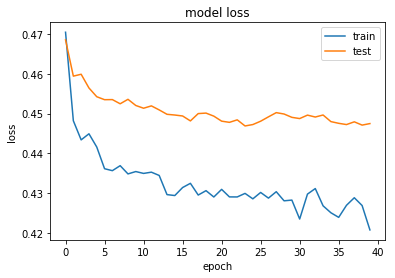

('avg auroc: ', 0.7126394810915249)
('avg precision: ', 0.4212328767123288)
('avg recall: ', 0.43462897526501765)
('avg accuracy: ', 0.7824074074074074)
('avg specificity: ', 0.8624898291293734)
('avg f1: ', 0.4278260869565217)
('auroc: ', [0.7126394810915249])
('precision: ', [0.4212328767123288])
('recall: ', [0.43462897526501765])
('accuracy: ', [0.7824074074074074])
('specificity: ', [0.8624898291293734])
('f1: ', [0.4278260869565217])
('threshold: ', [0.20670114])
CPU times: user 10min 1s, sys: 52.6 s, total: 10min 54s
Wall time: 7min 12s


In [53]:
%%time
seed(1)
set_random_seed(2)
auroc_list = []
precision_list = []
recall_list = []
accuracy_list = []
specificity_list = []
f1_list = []
th_list = []
for i in range(0,1):
    model = build_model(16, 0.5, 1, X_train_list[0][0].shape[0])
    history = fit_model(model, 40, X_train_list, y_train_list, X_test_list, y_test_list, verbose=1)
    y_predict = model.predict_generator(mygenerator(X_test_list), steps=len(X_test_list))
    y_predict = np.concatenate(y_predict)
    y_true = np.concatenate(y_test_list)
    auroc_list.append(auroc(y_predict, y_true))
    f1, th = find_best_f1(y_predict, y_true)
    f1_list.append(f1)
    th_list.append(th)
    precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    specificity_list.append(specificity)
print('avg auroc: ', np.mean(auroc_list))
print('avg precision: ', np.mean(precision_list))
print('avg recall: ', np.mean(recall_list))
print('avg accuracy: ', np.mean(accuracy_list))
print('avg specificity: ', np.mean(specificity_list))
print('avg f1: ', np.mean(f1_list))
print('auroc: ', auroc_list)
print('precision: ', precision_list)
print('recall: ', recall_list)
print('accuracy: ', accuracy_list)
print('specificity: ', specificity_list)
print('f1: ', f1_list)
print('threshold: ', th_list)

In [59]:
# from sklearn.calibration import calibration_curve
# # fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_predict, n_bins=10)
# fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_predict, normalize=True, n_bins=10)
# with open("exp_3_cal.csv", "w") as writeFile:
#     writer  = csv.writer(writeFile)
#     writer.writerows([fraction_of_positives, mean_predicted_value])
    
# plt.figure()
# plt.plot(mean_predicted_value, fraction_of_positives, 's-')
# plt.plot([0, 1], [0, 1], '--', color='gray')
# plt.show()

In [60]:
# import csv 
# fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)
# plot_roc_curve(fpr, tpr)
# with open("exp_3.csv", "w") as writeFile:
#     writer  = csv.writer(writeFile)
#     writer.writerows([fpr, tpr, [recall, 1-specificity]])

In [50]:
y_predict_t = model.predict_generator(mygenerator(X_train_list), steps=len(X_train_list))
y_predict_t = np.concatenate(y_predict_t)
y_true_t = np.concatenate(y_train_list)

f1_t, th_t = find_best_f1(y_predict_t, y_true_t)
precision_t, recall_t, accuracy_t, specificity_t = other_metrics(y_predict_t, y_true_t, th_t)

print('auroc: ', auroc(y_predict_t, y_true_t))
print('precision: ', precision_t)
print('recall: ', recall_t)
print('accuracy: ', accuracy_t)
print('specificity: ', specificity_t)
print('f1: ', f1_t);
print('threshold: ', th_t)

('auroc: ', 0.7544910250292967)
('precision: ', 0.3546448087431694)
('recall: ', 0.66359918200409)
('accuracy: ', 0.7156844285445302)
('specificity: ', 0.7274405723517193)
('f1: ', 0.4622507122507123)
('threshold: ', 0.18051799)


Epoch 1/40
2193/2193 [==============================] - 16s 7ms/step - loss: 0.3755 - binary_accuracy: 0.8711 - val_loss: 0.4686 - val_binary_accuracy: 0.8128
Epoch 2/40
2193/2193 [==============================] - 12s 6ms/step - loss: 0.3589 - binary_accuracy: 0.8709 - val_loss: 0.4596 - val_binary_accuracy: 0.8128
Epoch 3/40
2193/2193 [==============================] - 13s 6ms/step - loss: 0.3527 - binary_accuracy: 0.8710 - val_loss: 0.4599 - val_binary_accuracy: 0.8128
Epoch 4/40
2193/2193 [==============================] - 12s 5ms/step - loss: 0.3556 - binary_accuracy: 0.8706 - val_loss: 0.4564 - val_binary_accuracy: 0.8128
Epoch 5/40
2193/2193 [==============================] - 12s 5ms/step - loss: 0.3522 - binary_accuracy: 0.8706 - val_loss: 0.4542 - val_binary_accuracy: 0.8128
Epoch 6/40
2193/2193 [==============================] - 13s 6ms/step - loss: 0.3453 - binary_accuracy: 0.8701 - val_loss: 0.4535 - val_binary_accuracy: 0.8128
Epoch 7/40
2193/2193 [========================

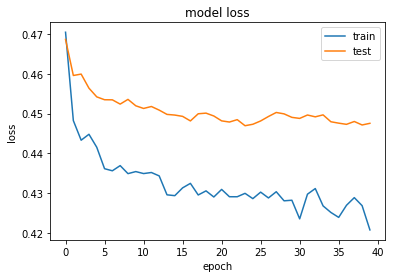

Epoch 1/40
2193/2193 [==============================] - 16s 7ms/step - loss: 0.3728 - binary_accuracy: 0.8707 - val_loss: 0.4663 - val_binary_accuracy: 0.8128
Epoch 2/40
2193/2193 [==============================] - 13s 6ms/step - loss: 0.3611 - binary_accuracy: 0.8711 - val_loss: 0.4613 - val_binary_accuracy: 0.8128
Epoch 3/40
2193/2193 [==============================] - 12s 5ms/step - loss: 0.3534 - binary_accuracy: 0.8711 - val_loss: 0.4558 - val_binary_accuracy: 0.8128
Epoch 4/40
2193/2193 [==============================] - 12s 5ms/step - loss: 0.3537 - binary_accuracy: 0.8717 - val_loss: 0.4546 - val_binary_accuracy: 0.8128
Epoch 5/40
2193/2193 [==============================] - 12s 6ms/step - loss: 0.3521 - binary_accuracy: 0.8713 - val_loss: 0.4536 - val_binary_accuracy: 0.8128
Epoch 6/40
2193/2193 [==============================] - 12s 6ms/step - loss: 0.3480 - binary_accuracy: 0.8719 - val_loss: 0.4535 - val_binary_accuracy: 0.8128
Epoch 7/40
2193/2193 [========================

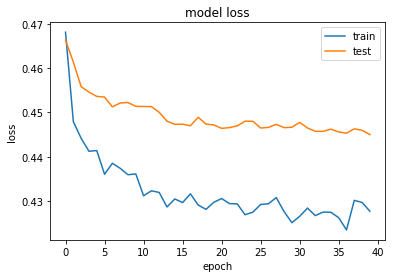

Epoch 1/40
2193/2193 [==============================] - 9s 4ms/step - loss: 0.3755 - binary_accuracy: 0.8711 - val_loss: 0.4707 - val_binary_accuracy: 0.8128
Epoch 2/40
2193/2193 [==============================] - 9s 4ms/step - loss: 0.3598 - binary_accuracy: 0.8711 - val_loss: 0.4635 - val_binary_accuracy: 0.8128
Epoch 3/40
2193/2193 [==============================] - 8s 3ms/step - loss: 0.3558 - binary_accuracy: 0.8712 - val_loss: 0.4606 - val_binary_accuracy: 0.8128
Epoch 4/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3535 - binary_accuracy: 0.8715 - val_loss: 0.4565 - val_binary_accuracy: 0.8128
Epoch 5/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3517 - binary_accuracy: 0.8714 - val_loss: 0.4579 - val_binary_accuracy: 0.8128
Epoch 6/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3500 - binary_accuracy: 0.8711 - val_loss: 0.4555 - val_binary_accuracy: 0.8128
Epoch 7/40
2193/2193 [==============================

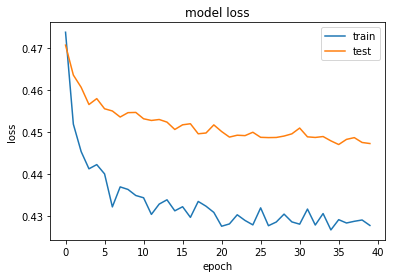

Epoch 1/40
2193/2193 [==============================] - 9s 4ms/step - loss: 0.3729 - binary_accuracy: 0.8707 - val_loss: 0.4693 - val_binary_accuracy: 0.8128
Epoch 2/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3610 - binary_accuracy: 0.8711 - val_loss: 0.4639 - val_binary_accuracy: 0.8128
Epoch 3/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3560 - binary_accuracy: 0.8713 - val_loss: 0.4627 - val_binary_accuracy: 0.8128
Epoch 4/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3539 - binary_accuracy: 0.8714 - val_loss: 0.4633 - val_binary_accuracy: 0.8128
Epoch 5/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3498 - binary_accuracy: 0.8718 - val_loss: 0.4613 - val_binary_accuracy: 0.8128
Epoch 6/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3506 - binary_accuracy: 0.8714 - val_loss: 0.4595 - val_binary_accuracy: 0.8128
Epoch 7/40
2193/2193 [==============================

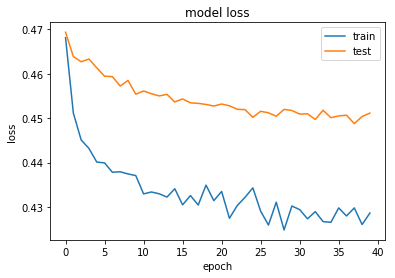

Epoch 1/40
2193/2193 [==============================] - 9s 4ms/step - loss: 0.3728 - binary_accuracy: 0.8711 - val_loss: 0.4665 - val_binary_accuracy: 0.8128
Epoch 2/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3581 - binary_accuracy: 0.8711 - val_loss: 0.4611 - val_binary_accuracy: 0.8128
Epoch 3/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3571 - binary_accuracy: 0.8712 - val_loss: 0.4577 - val_binary_accuracy: 0.8128
Epoch 4/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3496 - binary_accuracy: 0.8708 - val_loss: 0.4543 - val_binary_accuracy: 0.8128
Epoch 5/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3519 - binary_accuracy: 0.8716 - val_loss: 0.4543 - val_binary_accuracy: 0.8128
Epoch 6/40
2193/2193 [==============================] - 7s 3ms/step - loss: 0.3478 - binary_accuracy: 0.8721 - val_loss: 0.4520 - val_binary_accuracy: 0.8128
Epoch 7/40
2193/2193 [==============================

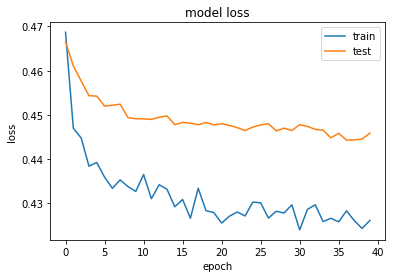

('avg auroc: ', 0.7145928632833726)
('avg precision: ', 0.3876231825984478)
('avg recall: ', 0.4763250883392226)
('avg accuracy: ', 0.7595238095238095)
('avg specificity: ', 0.8247355573637103)
('avg f1: ', 0.4257288345764746)
('auroc: ', [0.7126049791982334, 0.7168975897552379, 0.7138585479878208, 0.7129816248666645, 0.7166215746089066])
('precision: ', [0.42214532871972316, 0.37275064267352187, 0.36159600997506236, 0.37777777777777777, 0.40384615384615385])
('recall: ', [0.43109540636042404, 0.5123674911660777, 0.5123674911660777, 0.48056537102473496, 0.4452296819787986])
('accuracy: ', [0.783068783068783, 0.7473544973544973, 0.7394179894179894, 0.7546296296296297, 0.7731481481481481])
('specificity: ', [0.8641171684296176, 0.8014646053702197, 0.7917005695687551, 0.8177379983726607, 0.8486574450772986])
('f1: ', [0.4265734265734266, 0.431547619047619, 0.4239766081871345, 0.4230171073094867, 0.42352941176470593])
('threshold: ', [0.20718536, 0.18536751, 0.17276067, 0.17795178, 0.20798

In [51]:
%%time
seed(1)
set_random_seed(2)
auroc_list = []
precision_list = []
recall_list = []
accuracy_list = []
specificity_list = []
f1_list = []
th_list = []
for i in range(0,5):
    model = build_model(16, 0.5, 1, X_train_list[0][0].shape[0])
    history = fit_model(model, 40, X_train_list, y_train_list, X_test_list, y_test_list, verbose=1)
    y_predict = model.predict_generator(mygenerator(X_test_list), steps=len(X_test_list))
    y_predict = np.concatenate(y_predict)
    y_true = np.concatenate(y_test_list)
    auroc_list.append(auroc(y_predict, y_true))
    f1, th = find_best_f1(y_predict, y_true)
    f1_list.append(f1)
    th_list.append(th)
    precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    specificity_list.append(specificity)
print('avg auroc: ', np.mean(auroc_list))
print('avg precision: ', np.mean(precision_list))
print('avg recall: ', np.mean(recall_list))
print('avg accuracy: ', np.mean(accuracy_list))
print('avg specificity: ', np.mean(specificity_list))
print('avg f1: ', np.mean(f1_list))
print('auroc: ', auroc_list)
print('precision: ', precision_list)
print('recall: ', recall_list)
print('accuracy: ', accuracy_list)
print('specificity: ', specificity_list)
print('f1: ', f1_list)
print('threshold: ', th_list)

old results (wrong sdd)
unit: 8	epoch: 50	auroc_mean: 0.715993	auroc_std: 0.014383
unit: 8	epoch: 60	auroc_mean: 0.716188	auroc_std: 0.014191
unit: 8	epoch: 70	auroc_mean: 0.716360	auroc_std: 0.013688
unit: 8	epoch: 80	auroc_mean: 0.716965	auroc_std: 0.013612
unit: 8	epoch: 90	auroc_mean: 0.716444	auroc_std: 0.013414
unit: 8	epoch: 110	auroc_mean: 0.716207	auroc_std: 0.013120
unit: 8	epoch: 120	auroc_mean: 0.715924	auroc_std: 0.013136

unit: 4 	epoch: 100	auroc_mean: 0.714870	auroc_std: 0.016497
unit: 8 	epoch: 100	auroc_mean: 0.715778	auroc_std: 0.013265
unit: 16	epoch: 100	auroc_mean: 0.717123	auroc_std: 0.014345

unit: 8	epoch: 100	auroc_mean: 0.713937	auroc_std: 0.012976 dropout=0.4
unit: 8	epoch: 100	auroc_mean: 0.715778	auroc_std: 0.013265 dropout=0.5 
unit: 8	epoch: 100	auroc_mean: 0.712397	auroc_std: 0.014861 dropout=0.7
unit: 8	epoch: 100	auroc_mean: 0.711219	auroc_std: 0.013590 dropout=0.15

unit: 4	epoch: 50	auroc_mean: 0.714767	auroc_std: 0.016784
unit: 4	epoch: 70	auroc_mean: 0.715340	auroc_std: 0.016425
unit: 4	epoch: 80	auroc_mean: 0.715265	auroc_std: 0.016201
unit: 4	epoch: 90	auroc_mean: 0.714966	auroc_std: 0.016489
unit: 4	epoch: 100	auroc_mean: 0.714870	auroc_std: 0.016497
unit: 4	epoch: 110	auroc_mean: 0.715042	auroc_std: 0.016499
unit: 4	epoch: 120	auroc_mean: 0.714916	auroc_std: 0.016397

unit: 16	epoch: 25	auroc_mean: 0.716086	auroc_std: 0.015586
unit: 16	epoch: 30	auroc_mean: 0.716496	auroc_std: 0.015561
unit: 16	epoch: 35	auroc_mean: 0.717407	auroc_std: 0.015532
unit: 16	epoch: 40	auroc_mean: 0.717659	auroc_std: 0.015106 *
unit: 16	epoch: 45	auroc_mean: 0.717425	auroc_std: 0.015553
unit: 16	epoch: 50	auroc_mean: 0.717583	auroc_std: 0.015427
unit: 16	epoch: 60	auroc_mean: 0.717364	auroc_std: 0.015517
unit: 16	epoch: 75	auroc_mean: 0.717354	auroc_std: 0.014874

unit: 12	epoch: 40	auroc_mean: 0.716228	auroc_std: 0.014876
unit: 12	epoch: 50	auroc_mean: 0.716779	auroc_std: 0.014170
unit: 12	epoch: 60	auroc_mean: 0.716556	auroc_std: 0.013815
unit: 12	epoch: 70	auroc_mean: 0.716421	auroc_std: 0.013296
unit: 12	epoch: 80	auroc_mean: 0.716143	auroc_std: 0.012780

unit: 14	epoch: 40	auroc_mean: 0.714447	auroc_std: 0.014219
unit: 14	epoch: 50	auroc_mean: 0.715464	auroc_std: 0.013763

In [61]:
# %%time
# # K-Fold Cross Validation
# result = []
# pdic = [(16, [55], [0.5])]
# for unit, epoch_list, ratio_list in pdic:
#     for epoch in epoch_list:
#         for ratio in ratio_list:
#             auroc_list = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', verbose=1)
#             result.append((unit, epoch, auroc_list))
#             print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

learning rate 0.001:
unit: 16	epoch: 100	auroc_mean: 0.695739	auroc_std: 0.017014
unit: 24	epoch: 100	auroc_mean: 0.698280	auroc_std: 0.018764
unit: 32	epoch: 100	auroc_mean: 0.700865	auroc_std: 0.016971
unit: 40	epoch: 100	auroc_mean: 0.701996	auroc_std: 0.018621
unit: 40	epoch: 150	auroc_mean: 0.705638	auroc_std: 0.017872
unit: 40	epoch: 200	auroc_mean: 0.708169	auroc_std: 0.017475
unit: 50	epoch: 100	auroc_mean: 0.699599	auroc_std: 0.016310

unit: 50	epoch: 50	auroc_mean: 0.712041	auroc_std: 0.016337 (0.003)
unit: 50	epoch: 100	auroc_mean: 0.714913	auroc_std: 0.016200 (0.003)